In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import boto3
import os

s3 = boto3.client("s3")
BUCKET_NAME = "odzeradoai2"

In [3]:
import glob
import pandas as pd

current_path = os.getcwd()
parent_path = os.path.dirname(current_path)
data_path = os.path.join(parent_path, "data")
raw_data_path = os.path.join(data_path, 'raw')
modified_data_path = os.path.join(data_path, 'modified')
csv_files = glob.glob(os.path.join(raw_data_path, '*.csv'))


if csv_files:
    for csv_file in csv_files:
        print(f"Znaleziony plik CSV: {csv_file}")
        s3_path = "data/raw/" + os.path.basename(csv_file)
        print(f"Ścieżka S3: {s3_path}")

        ## UPLOAD
        s3.upload_file(
            Filename = csv_file,
            Bucket = BUCKET_NAME,
            Key = s3_path
        )

else:
    print("Nie znaleziono pliku CSV.")

Znaleziony plik CSV: c:\Users\pawel\Documents\apki\zad_mod_9\data\raw\halfmarathon_wroclaw_2023__final.csv
Ścieżka S3: data/raw/halfmarathon_wroclaw_2023__final.csv
Znaleziony plik CSV: c:\Users\pawel\Documents\apki\zad_mod_9\data\raw\halfmarathon_wroclaw_2024__final.csv
Ścieżka S3: data/raw/halfmarathon_wroclaw_2024__final.csv


In [4]:
## Sprawdzenie czy upload sie powiódł i dane są już na serwerze

response = s3.list_objects_v2(Bucket=BUCKET_NAME)

for obj in response["Contents"]:
    print(obj["Key"])

data/raw/halfmarathon_wroclaw_2023__final.csv
data/raw/halfmarathon_wroclaw_2024__final.csv


In [5]:
req_cols = ["Płeć", "Rocznik", "Czas", "5 km Tempo"]
combined_df = pd.DataFrame()


if "Contents" in response:
    for obj in response["Contents"]:
        key = obj["Key"]

        # Pomijamy foldery lub inne pliki nie-csv
        if not key.endswith('.csv'):
            continue

        print(f"Pobieranie: {key}")
        s3_path = f"s3://{BUCKET_NAME}/{key}"

        # Wczytaj CSV bezpośrednio z S3
        current_df = pd.read_csv(s3_path, sep=';')

        # Sprawdź wymagane kolumny
        if all(col in current_df.columns for col in req_cols):
            combined_df = pd.concat([combined_df, current_df[req_cols]], ignore_index=True)
        else:
            print(f"Pominięto plik {key} - brak wymaganych kolumn.")
else:
    print("Brak plików w folderze raw na S3.")

Pobieranie: data/raw/halfmarathon_wroclaw_2023__final.csv


f:\Users\pawel\miniconda3\envs\zm9\Lib\site-packages\fsspec\registry.py:294: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Pobieranie: data/raw/halfmarathon_wroclaw_2024__final.csv


In [6]:
import pandera as pa
schema = pa.DataFrameSchema(
    {
        "Płeć": pa.Column(str, pa.Check.isin(["M", "K"]), nullable=True),
        "Rocznik": pa.Column(float, nullable=True), # pa.Check.greater_than(1900.0),
        "Czas": pa.Column(str, nullable=True),
        "5 km Tempo": pa.Column(float, nullable=True) # pa.Check.greater_than(0),
    }
)



f:\Users\pawel\miniconda3\envs\zm9\Lib\site-packages\pandera\_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


In [7]:
try:
    schema.validate(combined_df, lazy=True)
except pa.errors.SchemaErrors as e:
    display(e.failure_cases)
    raise
combined_df

,Płeć,Rocznik,Czas,5 km Tempo
0,M,1992.0,01:04:59,2.923333
1,M,1986.0,01:06:23,2.960000
2,M,1996.0,01:08:24,3.153333
3,M,1988.0,01:10:16,3.236667
4,M,1995.0,01:10:27,3.240000
...,...,...,...,...
21952,K,1982.0,DNS,NaN
21953,K,1998.0,NaN,NaN
21954,M,1995.0,DNS,NaN
21955,K,1991.0,NaN,NaN


In [8]:
combined_df = combined_df.dropna(thresh=(0.8*len(combined_df.columns)))

In [9]:
combined_df["Czas"] = pd.to_timedelta(combined_df["Czas"]).dt.total_seconds()

C:\Users\pawel\AppData\Local\Temp\ipykernel_18880\1658544011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df["Czas"] = pd.to_timedelta(combined_df["Czas"]).dt.total_seconds()


In [10]:
combined_df = combined_df[combined_df['Rocznik'] > 1800]

Q1 = combined_df["Czas"].quantile(0.25)
Q3 = combined_df["Czas"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

combined_df = combined_df[~((combined_df["Czas"] < lower_bound) | (combined_df["Czas"] > upper_bound))]

In [11]:
combined_df.describe()

,Rocznik,Czas,5 km Tempo
count,17671.000000,17671.000000,17671.000000
mean,1984.406032,7346.141588,5.548499
std,10.190222,1145.384006,0.789929
min,1943.000000,4184.000000,0.000000
25%,1978.000000,6535.000000,4.993333
50%,1985.000000,7221.000000,5.520000
75%,1992.000000,8085.000000,6.080000
max,2006.000000,10500.000000,12.750000


In [12]:
schema_f = pa.DataFrameSchema(
    {
        "Płeć": pa.Column(str, pa.Check.isin(["M", "K"])),
        "Rocznik": pa.Column(float, pa.Check.greater_than(1900.0)),
        "Czas": pa.Column(float),
        "5 km Tempo": pa.Column(float, pa.Check.greater_than_or_equal_to(0))
    }
)

try:
    validated_df = schema_f.validate(combined_df, lazy=True)
except pa.errors.SchemaErrors as e:
    display(e.failure_cases)
    raise

In [13]:
from pycaret.regression import setup, pull, save_model
exp = setup(data=combined_df, target="Czas", session_id=7894)

,Description,Value
0,Session id,7894
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(17671, 4)"
4,Transformed data shape,"(17671, 4)"
5,Transformed train set shape,"(12369, 4)"
6,Transformed test set shape,"(5302, 4)"
7,Numeric features,2
8,Categorical features,1
9,Preprocess,True


In [14]:
best_raw_model = exp.compare_models()
raw_metrics_df = pull()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,293.0861,161027.3759,401.0920,0.8781,0.0517,0.0387,0.0590
lightgbm,Light Gradient Boosting Machine,297.0883,164862.7341,405.8526,0.8752,0.0523,0.0392,0.0680
lasso,Lasso Regression,294.9628,168546.5828,409.9829,0.8724,0.0576,0.0389,0.2110
ridge,Ridge Regression,294.9748,168617.5183,410.0653,0.8724,0.0575,0.0389,0.0090
lar,Least Angle Regression,294.9678,168617.6480,410.0652,0.8724,0.0575,0.0389,0.0090
llar,Lasso Least Angle Regression,294.9628,168546.5664,409.9829,0.8724,0.0576,0.0389,0.0090
br,Bayesian Ridge,294.9697,168617.6345,410.0652,0.8724,0.0575,0.0389,0.0090
lr,Linear Regression,294.9678,168617.6480,410.0652,0.8724,0.0575,0.0389,0.4150
omp,Orthogonal Matching Pursuit,295.3215,168932.2304,410.4681,0.8721,0.0577,0.0390,0.0090
huber,Huber Regressor,290.6300,171159.4980,413.1555,0.8704,0.0578,0.0381,0.0160


In [15]:
# transformed_exp = setup(
#     data=combined_df, 
#     target="Czas", 
#     # normalize=True,                       # wynik minimalnie lepszy tylko dla 3 metryk. Kompletnie bez znaczenia, dlatego pominięto
#     # normalize_method='zscore',
#     # transformation=True,                  # wynik gorszy od raw
#     # transformation_method="yeo-johnson", 
#     session_id=7894)

transformed_exp = exp # zachowanie transformed dla ew zmian/transformacji i możliwości szybkiego porównania w przyszłości

best_transformed_model = transformed_exp.compare_models()
transformed_metrics_df = pull()

best_transformed_model = transformed_exp.tune_model(best_transformed_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,293.0861,161027.3759,401.0920,0.8781,0.0517,0.0387,0.0590
lightgbm,Light Gradient Boosting Machine,297.0883,164862.7341,405.8526,0.8752,0.0523,0.0392,0.0590
lasso,Lasso Regression,294.9628,168546.5828,409.9829,0.8724,0.0576,0.0389,0.0080
ridge,Ridge Regression,294.9748,168617.5183,410.0653,0.8724,0.0575,0.0389,0.0090
lar,Least Angle Regression,294.9678,168617.6480,410.0652,0.8724,0.0575,0.0389,0.0100
llar,Lasso Least Angle Regression,294.9628,168546.5664,409.9829,0.8724,0.0576,0.0389,0.0090
br,Bayesian Ridge,294.9697,168617.6345,410.0652,0.8724,0.0575,0.0389,0.0090
lr,Linear Regression,294.9678,168617.6480,410.0652,0.8724,0.0575,0.0389,0.0090
omp,Orthogonal Matching Pursuit,295.3215,168932.2304,410.4681,0.8721,0.0577,0.0390,0.0090
huber,Huber Regressor,290.6300,171159.4980,413.1555,0.8704,0.0578,0.0381,0.0150


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,308.4524,173564.7509,416.6110,0.8691,0.0537,0.0406
1,300.1509,169057.6228,411.1662,0.8726,0.0527,0.0395
2,289.9319,161948.0153,402.4277,0.8753,0.0513,0.0382
3,290.9068,150178.0753,387.5282,0.8838,0.0504,0.0387
4,280.5220,146146.8570,382.2916,0.8874,0.0495,0.0371
5,301.5067,170158.2665,412.5024,0.8772,0.0526,0.0395
6,294.2949,152967.7821,391.1110,0.8812,0.0502,0.0389
7,291.9838,155429.4655,394.2454,0.8840,0.0510,0.0387
8,290.4056,177577.9322,421.4000,0.8684,0.0540,0.0384


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


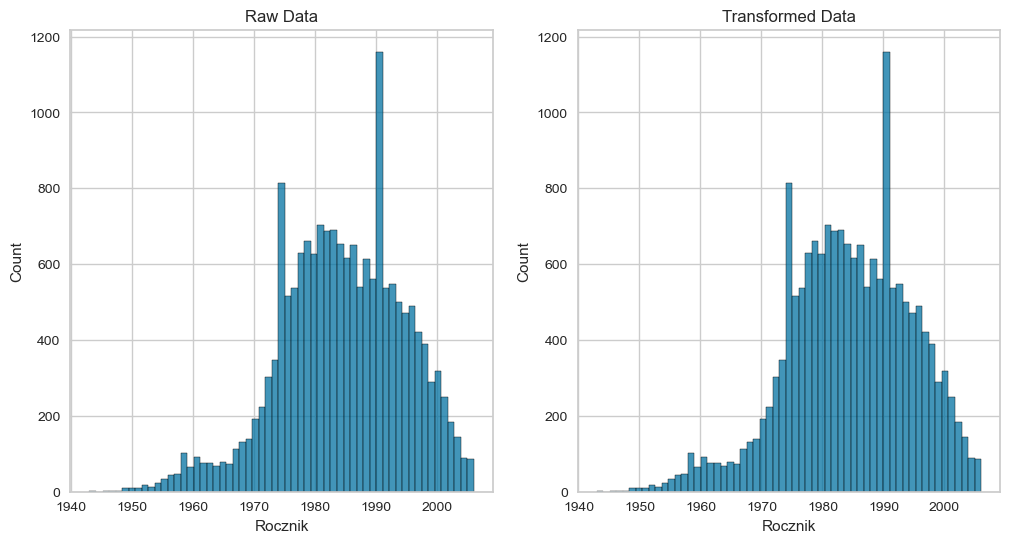

In [16]:
%matplotlib inline

import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(exp.dataset_transformed, x="Rocznik", ax=axes[0])
axes[0].set_title("Raw Data")
sns.histplot(transformed_exp.dataset_transformed, x="Rocznik", ax=axes[1])
axes[1].set_title("Transformed Data")

plt.show()

## w tym przypadku jest to bez sensu, bo porównujemy te same wykresy, zostawiam gdyby w przyszłości udało się lepiej ztuningować model

In [17]:
import numpy as np
import pandas as pd

metrics = ['MAE', 'MSE', 'RMSE', 'R2', 'RMSLE', 'MAPE']

# Przykładowo raw_metrics_df i transformed_metrics_df muszą być już wczytane

# Sortujemy po R2 i bierzemy TOP 5
top5_raw = raw_metrics_df.sort_values(by='R2', ascending=False).head(5)[['Model'] + metrics].copy()
top5_raw.insert(0, 'Dataset', 'RAW')

top5_trans = transformed_metrics_df.sort_values(by='R2', ascending=False).head(5)[['Model'] + metrics].copy()
top5_trans.insert(0, 'Dataset', 'TRANSFORMED')

# Zamiana wierszy na listę, żeby zrobić interleave (RAW, TRANSFORMED, RAW, TRANSFORMED, ...)
raw_rows = [top5_raw.iloc[i] for i in range(5)]
trans_rows = [top5_trans.iloc[i] for i in range(5)]

interleaved_rows = []
for i in range(5):
    interleaved_rows.append(raw_rows[i])
    interleaved_rows.append(trans_rows[i])

result_top5 = pd.DataFrame(interleaved_rows).reset_index(drop=True)

# Dodajemy kolumnę TOP z numerem pary (1,1,2,2,3,3,...)
top_numbers = np.repeat(np.arange(1, 6), 2)
result_top5.insert(0, 'TOP', top_numbers)

# W drugim wierszu każdej pary TOP ustawiamy pustą komórkę, by wizualnie scalic
for i in range(1, len(result_top5), 2):
    result_top5.at[i, 'TOP'] = ''

# Funkcja do kolorowania zwycięzców w parach
def highlight_winner_only(df):
    styles = pd.DataFrame('', index=df.index, columns=df.columns)
    for rank in range(0, len(df), 2):
        raw_row = df.iloc[rank]
        trans_row = df.iloc[rank + 1]
        for metric in metrics:
            if metric == 'R2':
                if raw_row[metric] > trans_row[metric]:
                    styles.loc[rank, metric] = 'background-color: green'
                elif raw_row[metric] < trans_row[metric]:
                    styles.loc[rank + 1, metric] = 'background-color: green'
            else:
                if raw_row[metric] < trans_row[metric]:
                    styles.loc[rank, metric] = 'background-color: green'
                elif raw_row[metric] > trans_row[metric]:
                    styles.loc[rank + 1, metric] = 'background-color: green'
    return styles

# Stworzenie stylera i wyświetlenie
styled_result = result_top5.style.apply(lambda _: highlight_winner_only(result_top5), axis=None)
styled_result


,TOP,Dataset,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1,RAW,Gradient Boosting Regressor,293.086100,161027.375900,401.092000,0.878100,0.051700,0.038700
1,,TRANSFORMED,Gradient Boosting Regressor,293.086100,161027.375900,401.092000,0.878100,0.051700,0.038700
2,2,RAW,Light Gradient Boosting Machine,297.088300,164862.734100,405.852600,0.875200,0.052300,0.039200
3,,TRANSFORMED,Light Gradient Boosting Machine,297.088300,164862.734100,405.852600,0.875200,0.052300,0.039200
4,3,RAW,Lasso Regression,294.962800,168546.582800,409.982900,0.872400,0.057600,0.038900
5,,TRANSFORMED,Lasso Regression,294.962800,168546.582800,409.982900,0.872400,0.057600,0.038900
6,4,RAW,Ridge Regression,294.974800,168617.518300,410.065300,0.872400,0.057500,0.038900
7,,TRANSFORMED,Ridge Regression,294.974800,168617.518300,410.065300,0.872400,0.057500,0.038900
8,5,RAW,Least Angle Regression,294.967800,168617.648000,410.065200,0.872400,0.057500,0.038900
9,,TRANSFORMED,Least Angle Regression,294.967800,168617.648000,410.065200,0.872400,0.057500,0.038900


In [18]:
best_model = transformed_exp.compare_models([best_raw_model, best_transformed_model]) #zwrócony model nieztuningowany, bo był lepszy

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
0,Gradient Boosting Regressor,293.0861,161027.3759,401.0920,0.8781,0.0517,0.0387,0.0640
1,Gradient Boosting Regressor,293.0861,161027.3759,401.0920,0.8781,0.0517,0.0387,0.0580


In [19]:
transformed_exp.predict_model(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,290.6950,155188.0165,393.9391,0.8796,0.0504,0.0383


,Płeć,Rocznik,5 km Tempo,Czas,prediction_label
16392,M,2000.0,5.746666,8088.0,7592.417417
13379,M,1972.0,5.720000,7128.0,7546.282314
3564,M,1992.0,5.416667,7051.0,7155.277560
14755,M,1988.0,5.620000,7531.0,7380.874313
1751,M,1979.0,4.950000,6382.0,6524.232260
...,...,...,...,...,...
13315,K,1983.0,5.570000,7111.0,7339.607130
16706,M,1977.0,5.943333,8218.0,7970.831467
11768,K,1988.0,5.430000,6687.0,7156.350372
18972,M,1981.0,7.000000,10114.0,9403.573115


In [20]:
save_model(best_model, 'best_halfmarathon_model', verbose=False)

(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Rocznik', '5 km Tempo'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(cols=['Płeć'],
                                                                handle_missing='return_nan',
                                                                mapping=[{'col': 'Płeć',
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
      

In [22]:
## UPLOAD
s3_path = "model/best_halfmarathon_model.pkl"

s3.upload_file(
    Filename = 'best_halfmarathon_model.pkl',
    Bucket = BUCKET_NAME,
    Key = s3_path
)